# MeerKAT Proposal Reviewer Allocation Problem

Richard Armstrong 
June 2022

Solve the Reviewer Assignment Problem for a set of MeerKAT Proposals

REQUIREMENTS
* Reviewers must have between 10 and 20 proposals to review 
* Some reviewers have requested a maximum of 10 proposals
* Proposals are reviewed 4 times each (`coverage`)
* Must exclude reviewers from reviewing proposals they are involved in

In [1]:
#!pip install --upgrade pip
#!pip install numpy matplotlib pandas openpyxl cvxopt

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from numpy import genfromtxt

%matplotlib inline 
pylab.rcParams['figure.figsize'] = 9, 6

In [3]:
coverage = 1   # Number of reviews per proposal
lower_bound_reviewer_load = 10 # Minimum number of reviews per reviewer

## Load Data

In [4]:
sci_cat = pd.read_csv('scientific_categories_MKT-22.csv', sep=',')
sc_dict = dict(sci_cat['CATEGORY NAME'])
sd = dict(zip(list(sc_dict.values()), list(sc_dict.keys())))


In [65]:
# load the list of proposals and their categories into a dataframe

df_cat = pd.read_csv('proposal_scientific_categories_MKT-22.csv', sep=';')
orphan_cat = pd.read_csv('Orphan_proposals.csv', sep=',',usecols = ['PSS ID','CATEGORY LIST'])
#df_cat['Category_List'] = df_cat['CATEGORY LIST'].apply(lambda x: eval(x))



for idx, sl in enumerate(orphan_cat['CATEGORY LIST']):
    cat_list = []
    for cat in sl.split('; '):
        cat_list.append(sd[cat])
    orphan_cat['CATEGORY LIST'][idx] = cat_list
    
#orphan_cat['Category_List'] = orphan_cat['CATEGORY LIST'].apply(lambda x: eval(x))
df_cat = orphan_cat
n_p = n_proposals = len(df_cat)
df_cat, n_p

(       PSS ID CATEGORY LIST
 0   MKT-22005        [2, 3]
 1   MKT-22006           [3]
 2   MKT-22008        [2, 3]
 3   MKT-22013        [1, 3]
 4   MKT-22015           [3]
 ..        ...           ...
 59  MKT-22146     [1, 4, 5]
 60  MKT-22149           [3]
 61  MKT-22150           [2]
 62  MKT-22153           [2]
 63  MKT-22159     [1, 3, 4]
 
 [64 rows x 2 columns],
 64)

In [11]:
# load the reviewer conflict dataframe
df_conflict = pd.read_csv('science_cross_check_MKT-22.csv', sep=';')
df_conflict['Proposals'] = df_conflict['PROPOSAL LIST'].apply(lambda x: x.strip('][').split(','))
print(df_conflict.shape)


for idx,conflict in enumerate(df_conflict['ID']):
    if conflict not in [1,2,7,12,31,39,42,54]:
        df_conflict.drop(idx, axis=0, inplace=True)

        #pd.concat([df_panel_conflict, df_conflict[df_conflict['ID'] == conflict]])

print(df_conflict.shape)
df_conflict

(33, 3)
(5, 3)


,ID,PROPOSAL LIST,Proposals
1,7,"[MKT-22043,MKT-22054]","[MKT-22043, MKT-22054]"
4,12,"[MKT-22004,MKT-22029,MKT-22032,MKT-22059,MKT-2...","[MKT-22004, MKT-22029, MKT-22032, MKT-22059, M..."
13,31,[MKT-22033],[MKT-22033]
20,39,[MKT-22135],[MKT-22135]
29,54,"[MKT-22004,MKT-22023,MKT-22025,MKT-22086,MKT-2...","[MKT-22004, MKT-22023, MKT-22025, MKT-22086, M..."


In [12]:
roe = np.genfromtxt('reviewer_observation_expertise_MKT-22.csv', delimiter=',', skip_header=1)
#poc = np.genfromtxt('proposal_observation_categories_MKT-22.csv', delimiter=',',skip_header=1)
#roe, poc

roe[:,1]

array([1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1.])

In [18]:
# load the self-identified reviewer competency scores per catagory into a dataframe

df_rev_score = pd.read_csv('reviewer_scientific_expertise_MKT-22.csv')
# df_rev_score.index = df_rev_score['REVIEWER ID']

# now we have to delete the reviewers who aren't panel members, and add Roger

Roger = df_rev_score[df_rev_score['REVIEWER ID']==61]
Roger['REVIEWER ID'] = 1

Roger['CATEGORY 1'] = 5
Roger['CATEGORY 2'] = 4
Roger['CATEGORY 3'] = 2
Roger['CATEGORY 4'] = 5
Roger['CATEGORY 5'] = 2
Roger['CATEGORY 6'] = 5
Roger['CATEGORY 7'] = 2
Roger['CATEGORY 8'] = 2
Roger['CATEGORY 9'] = 2
Roger['CATEGORY 10'] = 2
Roger['CATEGORY 11'] = 2
Roger['CATEGORY 12'] = 2
Roger['CATEGORY 13'] = 2

panel_score = pd.DataFrame()
panel_score = panel_score.append(Roger)
print(Roger, panel_score)

p_score = pd.read_csv('MKT-22_panel_reviewers_expertise_anon.csv')

for el in np.array(p_score['ID']):
    panel_score = panel_score.append(df_rev_score[df_rev_score['REVIEWER ID']==el])

n_panelists = len(panel_score)
panel_score['N_max'] = np.ones(n_panelists)
panel_score.columns = ['CATEGORY ID',1,2,3,4,5,6,7,8,9,10,11,12,13,'N_max']
og_pan_idx = np.array(panel_score['CATEGORY ID'])
panel_score

    REVIEWER ID  CATEGORY 1  CATEGORY 2  CATEGORY 3  CATEGORY 4  CATEGORY 5  \
46            1           5           4           2           5           2   

    CATEGORY 6  CATEGORY 7  CATEGORY 8  CATEGORY 9  CATEGORY 10  CATEGORY 11  \
46           5           2           2           2            2            2   

    CATEGORY 12  CATEGORY 13  
46            2            2       REVIEWER ID  CATEGORY 1  CATEGORY 2  CATEGORY 3  CATEGORY 4  CATEGORY 5  \
46            1           5           4           2           5           2   

    CATEGORY 6  CATEGORY 7  CATEGORY 8  CATEGORY 9  CATEGORY 10  CATEGORY 11  \
46           5           2           2           2            2            2   

    CATEGORY 12  CATEGORY 13  
46            2            2  


/var/folders/sv/qb42549d40g_hkh5d0zdkw340000gn/T/ipykernel_33060/2627860443.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Roger['REVIEWER ID'] = 1
/var/folders/sv/qb42549d40g_hkh5d0zdkw340000gn/T/ipykernel_33060/2627860443.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Roger['CATEGORY 1'] = 5
/var/folders/sv/qb42549d40g_hkh5d0zdkw340000gn/T/ipykernel_33060/2627860443.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

,CATEGORY ID,1,2,3,4,5,6,7,8,9,10,11,12,13,N_max
46,1,5,4,2,5,2,5,2,2,2,2,2,2,2,1.0
0,2,1,0,2,3,0,3,3,5,2,6,4,2,2,1.0
3,7,6,5,3,4,4,3,2,2,2,4,2,2,2,1.0
6,12,4,3,6,3,4,4,5,3,1,3,2,2,1,1.0
17,31,5,2,4,5,5,5,2,2,0,5,0,2,0,1.0
25,39,6,4,6,6,6,4,1,3,0,4,0,0,0,1.0
28,42,2,2,2,2,1,4,4,3,6,2,2,4,6,1.0
40,54,6,0,6,0,5,4,3,0,0,0,0,0,0,1.0


In [14]:
#rev_score = genfromtxt('reviewer_scientific_expertise_MKT-22.csv', delimiter=',')

# Create vector with max number of reviews per reviewer 
n_r = n_reviewers = len(df_rev_score)
reviewers_props = 20*np.ones(n_r)
#limit10_list = [28,29]
#reviewers_props[limit10_list] = 10
df_rev_score['N_max'] = reviewers_props  # Make column with max number of reviews for each reviewer

scientific_categories = pd.read_csv('scientific_categories_MKT-22.csv')
scientific_categories.index = scientific_categories['CATEGORY ID']

df_rev_score.columns = ['CATEGORY ID',1,2,3,4,5,6,7,8,9,10,11,12,13,'N_max']

og_rev_idx = np.array(df_rev_score['CATEGORY ID'])

df_rev_score.head(21)
#np.column_stack((og_rev_idx, np.array(df_rev_score[11]), roe[:,1]))

,CATEGORY ID,1,2,3,4,5,6,7,8,9,10,11,12,13,N_max
0,2,1,0,2,3,0,3,3,5,2,6,4,2,2,20.0
1,4,2,3,4,4,2,0,0,1,0,0,0,0,0,20.0
2,6,3,1,3,5,5,4,4,0,1,2,0,3,2,20.0
3,7,6,5,3,4,4,3,2,2,2,4,2,2,2,20.0
4,9,3,1,6,2,3,1,3,1,0,0,0,0,3,20.0
5,10,4,3,3,5,3,3,1,3,1,1,1,1,1,20.0
6,12,4,3,6,3,4,4,5,3,1,3,2,2,1,20.0
7,13,6,0,3,1,3,3,4,2,3,3,5,4,5,20.0
8,14,3,0,0,0,0,0,1,2,5,0,1,3,6,20.0
9,15,0,1,3,4,0,5,0,2,1,0,0,0,0,20.0


In [15]:
print('reviewers, proposals, panelists: ', n_r, n_p, n_panelists)

reviewers, proposals, panelists:  47 132 8


In [21]:
# do the dirty
n_r = n_panelists
df_rev_score = panel_score
df_rev_score['CATEGORY ID']

46     1
0      2
3      7
6     12
17    31
25    39
28    42
40    54
Name: CATEGORY ID, dtype: int64

## Derived Data Structures

In [24]:
# create a binary numpy array(/mask) from the reviewer conflict dataframe: 
# i.e. set to 0 if conflict, else 1
conflict_mask = np.ones((n_r, len(df_cat)))

print(conflict_mask.shape)
print('total number of conflicts in mask before: ', conflict_mask.flatten().shape[0] - np.count_nonzero(conflict_mask))

rev_idx = np.array(df_rev_score['CATEGORY ID'].index)

for row_idx, row in df_conflict.iterrows():
    rev_pos = int(*np.where(og_pan_idx==row[0]))
    for col_idx, prop in enumerate(df_conflict['Proposals'][row_idx]):
        if not df_cat[df_cat['PSS ID'] == prop].empty:
            prop_pos = df_cat[df_cat['PSS ID'] == prop].index[0]
            print(prop, col_idx, rev_pos, prop_pos)
            conflict_mask[int(rev_pos)][prop_pos] = 0
        
print('total number of conflicts in mask after: ', conflict_mask.flatten().shape[0] - np.count_nonzero(conflict_mask))

#print(conflict_mask[n_r-3], n_r-3, conflict_mask.shape)

#print(f'number of conflicts for each reviewer: \n{np.column_stack((og_rev_idx,n_p-np.sum(conflict_mask, axis=1))).astype(int)}')

#print(f'sum of conflicts: {int(np.sum(n_p-np.sum(conflict_mask, axis=1)))}')

(8, 64)
total number of conflicts in mask before:  0
MKT-22054 1 2 22
MKT-22029 1 3 9
MKT-22032 2 3 10
MKT-22059 3 3 23
MKT-22069 4 3 26
MKT-22101 5 3 37
MKT-22122 6 3 47
MKT-22033 0 4 11
MKT-22135 0 5 53
MKT-22023 1 7 7
MKT-22086 3 7 31
MKT-22116 4 7 44
total number of conflicts in mask after:  12


In [25]:
# create a binary array (/mask) of reviewer expertise > .0
zeroes_mask = np.where(np.array(df_rev_score.transpose()) > 0., 1, 0)[1:-1]
np.count_nonzero(zeroes_mask), zeroes_mask.shape

(87, (13, 8))

In [85]:
# create a numerical array of the reviewer scores dataframe
rev_scores = np.array(df_rev_score.transpose())[1:-1]
np.count_nonzero(rev_scores), rev_scores.shape[0], rev_scores.shape[1]


rev_scores

array([[5., 1., 6., 4., 5., 6., 2., 6.],
       [4., 0., 5., 3., 2., 4., 2., 0.],
       [2., 2., 3., 6., 4., 6., 2., 6.],
       [5., 3., 4., 3., 5., 6., 2., 0.],
       [2., 0., 4., 4., 5., 6., 1., 5.],
       [5., 3., 3., 4., 5., 4., 4., 4.],
       [2., 3., 2., 5., 2., 1., 4., 3.],
       [2., 5., 2., 3., 2., 3., 3., 0.],
       [2., 2., 2., 1., 0., 0., 6., 0.],
       [2., 6., 4., 3., 5., 4., 2., 0.],
       [2., 4., 2., 2., 0., 0., 2., 0.],
       [2., 2., 2., 2., 2., 0., 4., 0.],
       [2., 2., 2., 1., 0., 0., 6., 0.]])

## Plots

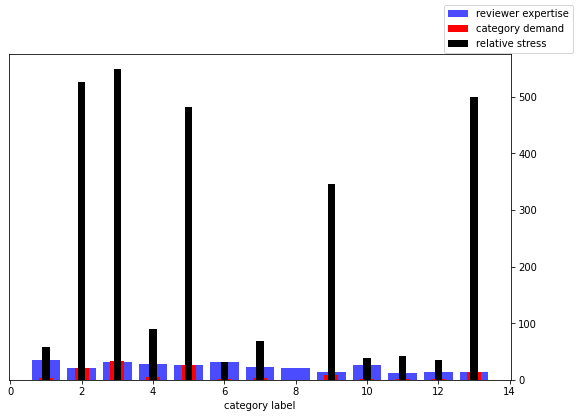

In [29]:
# Make a bar plot of all the proposal categories and numerical reviewer expertise 

all_topics_list = []
all_topics_count = np.zeros(df_rev_score.transpose()[1:-1].shape[0])

for idx, topic_set in enumerate(df_cat['CATEGORY LIST']): # run through each proposal
    #print(idx, topic_set)
    for topic in topic_set: # run through each topic in each proposal
        all_topics_count[topic-1] += 1 # add one to the demand per mention
        #print(topic, df_rev_score[topic][1])
        all_topics_list.append(topic)
        
fig, ax = plt.subplots()#figsize=(16,8))

ax.bar(range(1, rev_scores.shape[0]+1), [row.sum() for row in rev_scores], alpha=0.7, label = 'reviewer expertise', color='b')
ax.bar(range(1,rev_scores.shape[0]+1), all_topics_count, label = 'category demand', color = 'r', width=0.4)
#ax.hist(np.array(all_topics_list), histtype='step', linewidth=3, align='mid', bins=1000, label = 'category demand')

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.bar(range(1,rev_scores.shape[0]+1), 5*10**2*np.array(all_topics_count)[0:13]/[row.sum() for row in rev_scores][0:13], width=0.2, label = 'relative stress', color='k')

fig.legend()
plt.xlabel('category label')
plt.savefig('relative_stress.png')

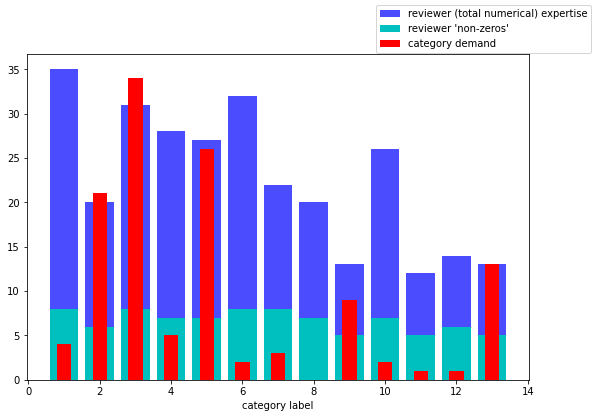

In [30]:
# Make a bar plot of all the proposal categories and binary reviewer expertise 
    
fig, ax = plt.subplots()
ax.bar(range(1,14), [row.sum() for row in rev_scores], alpha=0.7, label = 'reviewer (total numerical) expertise', color='b')
ax.bar(range(1, rev_scores.shape[0]+1), [row.sum() for row in zeroes_mask], label = 'reviewer \'non-zeros\'', color='c')
ax.bar(range(1,rev_scores.shape[0]+1), all_topics_count, label = 'category demand', color = 'r', width=0.4)

plt.xlabel('category label')
fig.legend()
plt.show()

## Affinity Matrix

In [31]:
df_prop_obs_cat = pd.read_csv('proposal_observation_categories_MKT-22.csv', sep=',')
df_prop_obs_cat[df_prop_obs_cat['PSS ID']=='MKT-22005']

,PSS ID,CATEGORY
2,MKT-22005,1


In [32]:
df_rev_obs_exp = pd.read_csv('reviewer_observation_expertise_MKT-22.csv', sep=',')
df_rev_obs_exp[df_rev_obs_exp['REVIEWER ID']==1]

,REVIEWER ID,OCAT1,OCAT2,OCAT3


In [34]:
#SCRATCH
orphan_obs_cat_l = []
for idx, prop in enumerate(orphan_cat['PSS_ID']):
    #print(int(df_prop_obs_cat[df_prop_obs_cat['PSS ID']==prop]['CATEGORY']))
    orphan_obs_cat_l.append(int(df_prop_obs_cat[df_prop_obs_cat['PSS ID']==prop]['CATEGORY']))

orphan_obs_cat = np.array(orphan_obs_cat_l)

In [99]:
# ---------------
# AFFINITY MATRIX
# ---------------

# create the affinity matrix
affinity = np.zeros((len(df_rev_score),len(df_cat)))

print('creation done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])
#affinity

# set the affinity to the MAXimum of ANY keyword
max = 0
for row_idx, row in enumerate(affinity):
    #print(row_idx, row)
    #for cell_idx, cell in enumerate(row):
    for cell_idx, topic_set in enumerate(df_cat['CATEGORY LIST']):
        #print(topic_set, cell_idx)
        for topic in topic_set:
         #   print(topic)
            max = np.maximum(max, rev_scores[topic-1][row_idx])
        affinity[row_idx, cell_idx] = max/10 # normalise to between 0 and 1
        max=0
        
print('set up affinities done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])

#-----------        
     
# Set constraints in the affinity matrix :
# i.e. 1. Maximum over observation categories 
#      2. Make sure there are not zeros in EVERY category, 
#      3. reviewer/proposal conflicts (science_cross_check)
# by setting affinity to 0 (which is actually a soft constraint, but wusually suffices)

# Observation Category
rev_obs_exp = np.genfromtxt('reviewer_observation_expertise_MKT-22.csv', delimiter=',', skip_header=1)
prop_obs_cat = np.genfromtxt('proposal_observation_categories_MKT-22.csv', delimiter=',', skip_header=1)[:,1]

df_rev_obs_exp = pd.read_csv('reviewer_observation_expertise_MKT-22.csv', sep=',')
df_prop_obs_cat = pd.read_csv('proposal_observation_categories_MKT-22.csv', sep=',')

orphan_obs_cat_l = []
for idx, prop in enumerate(orphan_cat['PSS ID']):
    #print(int(df_prop_obs_cat[df_prop_obs_cat['PSS ID']==prop]['CATEGORY']))
    orphan_obs_cat_l.append(int(df_prop_obs_cat[df_prop_obs_cat['PSS ID']==prop]['CATEGORY']))

orphan_obs_cat = np.array(orphan_obs_cat_l)

panel_obs_exp = np.array([1,1,1,0]) #Roger special case
for idx, pan in enumerate(panel_score['CATEGORY ID']):
    panel_obs_exp = np.row_stack([panel_obs_exp, np.array(df_rev_obs_exp[df_rev_obs_exp['REVIEWER ID']==pan])])
    

for row_idx, row in enumerate(panel_obs_exp):
    #print (rev_obs_exp[row_idx][1:])
    for col_idx, col in enumerate(orphan_obs_cat):
        #print (row_idx, col_idx, col, row[1:])
        if row[int(col)] == 0: 
            #print (affinity[row_idx][col_idx])
            affinity[row_idx][col_idx] = 0.
print('Obs cat done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])

            
# check there is at least one non-zero
'''set_zero = False
for row_idx, row in enumerate(affinity):#row_idx is reviewer ID
    for cell_idx, topic_set in enumerate(df_cat['Category_List']):#cell_idx is the proposal id, topic_set is the list of topics
        for topic in topic_set:
            if df_rev_score[topic][row_idx]==0.: set_zero = True # if there are ANY '0' experience ratings
        if set_zero == True: affinity[row_idx, cell_idx] = 0.
        set_zero = False

print('at least one nonzero done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])
'''

# mask out conflicts of interest:
affinity = affinity*conflict_mask
print('set conflicts done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])


'''
# apply a non-linear scaling to the affinity 
affinity = affinity + np.where(affinity>0.3, 0.4, 0.)
print('non_linear scaling done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])
'''
affinity[0]

creation done (8, 64) zeros: 512 of 512
set up affinities done (8, 64) zeros: 40 of 512
Obs cat done (8, 64) zeros: 153 of 512
set conflicts done (8, 64) zeros: 161 of 512


array([0.4, 0.2, 0.4, 0.5, 0.2, 0.4, 0.5, 0.4, 0.2, 0.4, 0.4, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.5, 0.4, 0.4, 0.2, 0.2, 0.2, 0.4, 0.2, 0.2,
       0.4, 0.5, 0.5, 0.2, 0.2, 0.4, 0.4, 0.2, 0.2, 0.2, 0.2, 0.4, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.5, 0.2, 0.4, 0.2, 0.2, 0.5, 0.2,
       0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.4, 0.5, 0.2, 0.4, 0.4, 0.5])

In [97]:
panel_score, rev_scores.transpose().astype(int)
orphan_obs_cat, panel_obs_exp

(array([1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
        2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1,
        2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2]),
 array([[ 1,  1,  1,  0],
        [ 2,  1,  1,  1],
        [ 7,  1,  1,  1],
        [12,  0,  1,  0],
        [31,  1,  1,  1],
        [39,  1,  1,  0],
        [42,  0,  1,  1],
        [54,  0,  1,  0]]))

## Prepare arrays for LP

In [38]:
# --------------------------------------------------------------------------------------------
# convert arrays to a set of stored numpy arrays for the Linear Program (LP) optimisation code
# --------------------------------------------------------------------------------------------

# assign the maximum number of proposals per reviewer
#loads = np.genfromtxt('science_max_reviews.csv', skip_header=1, delimiter=',')[:,1]

# set the lower bound of proposals to review to be 10
#loads_lb = 10*np.ones(affinity.shape[0])

# set the coverage (i.e. number of reviews per paper) to be exactly 4
#covs = 4*np.ones(affinity.shape[1])

loads = loads_lb = 8*np.ones(affinity.shape[0])
covs = np.ones(affinity.shape[1])

loads_lb.shape, loads.shape



((8,), (8,))

-------------------------------------------------

In [39]:
# save array to disk, to transfer to server with Gurobi license
np.save('scores.npy', affinity)
np.save('loads.npy', loads)
np.save('loads-lb.npy', loads_lb)
np.save('covs.npy', covs)

### Note: move to sherlock

+ copy over scores.npy (the storage name of the afinity matrix) to sherlock.sdp.kat.ac.za (which has the gurobi license file):
`
rsync -avz scores.npy richarms@sherlock.sdp.kat.ac.za:/home/richarms/src/fair-matching/data/mk/
`
+ then:
`ssh sherlock.sdp.kat.ac.za`
+ run the linear program
`
cd /home/richarms/src/fair-matching
source venv/bin/activate
source bin/setup.sh
sh bin/exp/basic.sh config/mk/basic-lb.json
exit
`
+ and copy back the assignment.npy 

`rsync -avz richarms@sherlock.sdp.kat.ac.za:/home/richarms/src/fair-matching/exp_out/mk/basic-lb/{DATE}/results/assignment.npy .`

## Code to evaluate LP result


In [42]:
# load the assignment matrix from the LP
# The assignment matrix is a sparse binary array of dim n_reviewers * n_proposals 
# with nonzero entries for a positive assignment
assignment = np.load('assignment.npy')
assignment = assignment.astype(int)
assignment[np.where(og_rev_idx==2)].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0]), array([ 2,  3, 17, 23, 37, 50, 54, 59]))

In [60]:
# Do manual adjustments (highly risky!)
at = assignment.transpose()
#at[np.where(df_cat['PSS ID']=='MKT-22003'), np.where(og_rev_idx==32)] = 0
#at[np.where(df_cat['PSS ID']=='MKT-22003'), np.where(og_rev_idx==40)] = 1
#at[np.where(df_cat['PSS ID']=='MKT-22155'), np.where(og_rev_idx==34)] = 0
#at[np.where(df_cat['PSS ID']=='MKT-22155'), np.where(og_rev_idx==26)] = 1

#assignment[np.where(og_rev_idx==40)].nonzero()
#at[np.where(df_cat['PSS ID']=='MKT-22155'), np.where(og_rev_idx==26)]
np.count_nonzero(assignment)

64

In [45]:
## CHECK
## Sanity check -- check that the trace of the affinity and assignment match that produced by LP
np.sum(np.diag(np.matmul(np.transpose(affinity), assignment))), np.trace(np.matmul(np.transpose(affinity), assignment))

(29.7, 29.7)

In [62]:
# SCRATCH
print(np.count_nonzero(np.transpose(assignment)[0]))
print(np.transpose(assignment)[0])
print(np.count_nonzero((assignment)[0]))
print((assignment).transpose()[-5].nonzero())

print(assignment)

1
[0 0 1 0 0 0 0 0]
8
(array([0]),)
[[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [68]:
# Gene Matrix
################

# The assignment matrix may be expressed as a 'gene matrix' (an inherited term): a dense array 
# of reviewers assigned to each proposal, (as opposed to the assignment matrix, which is a sparse binary 
# array of dim n_reviewers * n_proposals with nonzero entries for a positive assignment)
gene_matrix = np.zeros((n_p, coverage))
gene_matrix_indexes = np.zeros((n_p, coverage))

print(gene_matrix.shape)

# original reviewer index
#og_rev_idx = np.array(df_rev_score['CATEGORY ID'])

# The reviewer_assignment is the logical opposite of the gene matrix: for each reviewer,
# it is a list of their associated proposals
reviewer_assignment = np.empty((n_panelists), dtype=object)

# set the first element of the reviewer assignment vector to be the original reviewer 
# index, as a string
for idx, r in enumerate(reviewer_assignment):
    reviewer_assignment[idx] = str(og_pan_idx[idx])



for col_idx, col in enumerate(assignment.transpose()):
    # set the gene matrix to the indices of each non-zero element in the assignment
    gene_matrix[col_idx] = np.nonzero(col)[0]
    # set up the correct original reviewer IDs
    for rev_idx, rev in enumerate(gene_matrix[col_idx]):
        gene_matrix_indexes[col_idx][rev_idx] = og_pan_idx[int(rev)]
    # augment the string with each fo the {n_min, n_max} proposals that reviewer should review
    for i in np.nonzero(col)[0]:
        reviewer_assignment[i] = reviewer_assignment[i] + ', ' + df_cat['PSS ID'][col_idx]

        
gene_matrix = gene_matrix.astype(int)
gene_matrix_indexes = gene_matrix_indexes.astype(int)

print("This is the LP result, expressed as a set of (4) reviewers (by original ID) per proposal: \n", 
      np.column_stack((df_cat['PSS ID'], gene_matrix_indexes)))

print(reviewer_assignment)


(64, 1)
This is the LP result, expressed as a set of (4) reviewers (by original ID) per proposal: 
 [['MKT-22005' 7]
 ['MKT-22006' 39]
 ['MKT-22008' 1]
 ['MKT-22013' 1]
 ['MKT-22015' 2]
 ['MKT-22017' 42]
 ['MKT-22018' 12]
 ['MKT-22023' 12]
 ['MKT-22027' 31]
 ['MKT-22029' 7]
 ['MKT-22032' 7]
 ['MKT-22033' 42]
 ['MKT-22034' 31]
 ['MKT-22037' 39]
 ['MKT-22038' 2]
 ['MKT-22039' 7]
 ['MKT-22044' 31]
 ['MKT-22045' 1]
 ['MKT-22046' 12]
 ['MKT-22048' 54]
 ['MKT-22049' 39]
 ['MKT-22050' 31]
 ['MKT-22054' 42]
 ['MKT-22059' 1]
 ['MKT-22064' 2]
 ['MKT-22065' 31]
 ['MKT-22069' 54]
 ['MKT-22072' 42]
 ['MKT-22075' 54]
 ['MKT-22077' 54]
 ['MKT-22079' 54]
 ['MKT-22086' 12]
 ['MKT-22089' 7]
 ['MKT-22090' 31]
 ['MKT-22094' 39]
 ['MKT-22096' 54]
 ['MKT-22098' 2]
 ['MKT-22101' 1]
 ['MKT-22102' 12]
 ['MKT-22104' 39]
 ['MKT-22107' 2]
 ['MKT-22108' 2]
 ['MKT-22110' 7]
 ['MKT-22111' 2]
 ['MKT-22116' 12]
 ['MKT-22118' 42]
 ['MKT-22119' 39]
 ['MKT-22122' 42]
 ['MKT-22129' 42]
 ['MKT-22130' 39]
 ['MKT-22131' 1]
 

In [75]:
panel_score
#gene_matrix_indexes[-5]

,CATEGORY ID,1,2,3,4,5,6,7,8,9,10,11,12,13,N_max
46,1,5,4,2,5,2,5,2,2,2,2,2,2,2,1.0
0,2,1,0,2,3,0,3,3,5,2,6,4,2,2,1.0
3,7,6,5,3,4,4,3,2,2,2,4,2,2,2,1.0
6,12,4,3,6,3,4,4,5,3,1,3,2,2,1,1.0
17,31,5,2,4,5,5,5,2,2,0,5,0,2,0,1.0
25,39,6,4,6,6,6,4,1,3,0,4,0,0,0,1.0
28,42,2,2,2,2,1,4,4,3,6,2,2,4,6,1.0
40,54,6,0,6,0,5,4,3,0,0,0,0,0,0,1.0


In [106]:
# Save proposal assignments and reviewer assignemnts to CSV files
pd.DataFrame(np.column_stack((df_cat['PSS ID'], gene_matrix_indexes.astype(int)))).to_csv('Orphan_assignment.csv')
pd.DataFrame(np.column_stack((og_pan_idx, reviewer_assignment))).to_csv('Panel_assignment.csv')

Fernando's matrix zeros:  0
Fernando's Extended zeros:  17
Fernando's matrix: mean, median, minimum sum: 5.0 4.734375 2
[[5 'MKT-22005']
 [6 'MKT-22006']
 [4 'MKT-22008']
 [5 'MKT-22013']
 [2 'MKT-22015']
 [6 'MKT-22017']
 [6 'MKT-22018']
 [4 'MKT-22023']
 [5 'MKT-22027']
 [5 'MKT-22029']
 [5 'MKT-22032']
 [6 'MKT-22033']
 [5 'MKT-22034']
 [6 'MKT-22037']
 [4 'MKT-22038']
 [4 'MKT-22039']
 [5 'MKT-22044']
 [5 'MKT-22045']
 [3 'MKT-22046']
 [5 'MKT-22048']
 [6 'MKT-22049']
 [5 'MKT-22050']
 [6 'MKT-22054']
 [4 'MKT-22059']
 [2 'MKT-22064']
 [5 'MKT-22065']
 [5 'MKT-22069']
 [6 'MKT-22072']
 [5 'MKT-22075']
 [6 'MKT-22077']
 [5 'MKT-22079']
 [3 'MKT-22086']
 [5 'MKT-22089']
 [5 'MKT-22090']
 [6 'MKT-22094']
 [6 'MKT-22096']
 [3 'MKT-22098']
 [4 'MKT-22101']
 [6 'MKT-22102']
 [6 'MKT-22104']
 [2 'MKT-22107']
 [2 'MKT-22108']
 [4 'MKT-22110']
 [2 'MKT-22111']
 [3 'MKT-22116']
 [6 'MKT-22118']
 [6 'MKT-22119']
 [2 'MKT-22122']
 [6 'MKT-22129']
 [6 'MKT-22130']
 [5 'MKT-22131']
 [6 'MKT-2213

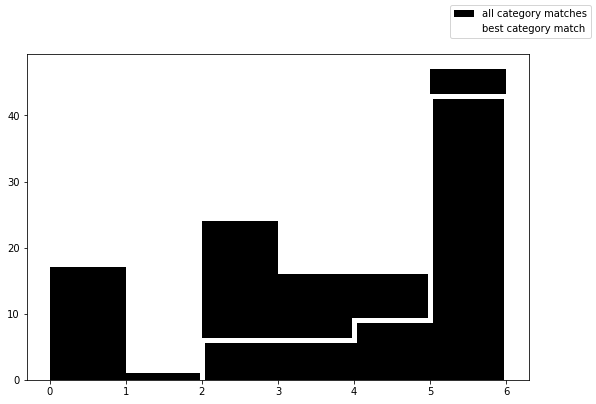

In [105]:
# -----------
# Fernando's Matrix 
# -----------

# max reviewer score matrix ('Fernando's Matrix')
rev_max_arr = np.zeros((n_p, 1))
hi_cont_arr = np.zeros((n_p, 1))
# all reviewer score list ('Extended Fernando's List')
all_assigned_affinities = []
all_hicont_scores = []


for cell_idx, topic_set in enumerate(df_cat['CATEGORY LIST']):#iterate over proposals
    rev_a = np.zeros(1)
    hi_a = np.zeros(1)
    for topic in topic_set: #iterate over topic proposals
        if (topic <= 13):
            for rev_idx, rev in enumerate(gene_matrix[cell_idx]):#iterate over reviewers
                rev_a[rev_idx] = np.maximum(rev_a[rev_idx], rev_scores[topic-1][rev])
                all_assigned_affinities.append(rev_scores[topic-1][rev])
                #print(cell_idx, topic, rev_idx, rev, rev_scores[topic-1][rev])
        else:
            for rev_idx, rev in enumerate(gene_matrix[cell_idx]):#iterate over reviewers
                hi_a[rev_idx] = np.maximum(hi_a[rev_idx], rev_scores[topic-1][rev])
                all_hicont_scores.append(rev_scores[topic-1][rev])
        
    #print(rev_a.astype(int))#, hi_a.astype(int))
    rev_max_arr[cell_idx] = rev_a
    hi_cont_arr[cell_idx] = hi_a
    
print('Fernando\'s matrix zeros: ', rev_max_arr.flatten().shape[0] - np.count_nonzero(rev_max_arr))
print('Fernando\'s Extended zeros: ', len(all_assigned_affinities) - np.count_nonzero(np.array(all_assigned_affinities)))

fig, ax = plt.subplots()
ax.hist(all_assigned_affinities, bins=int(np.max(all_assigned_affinities)-np.min(all_assigned_affinities)),histtype='stepfilled', linewidth=5,  label='all category matches', color='k')
ax.hist(rev_max_arr.astype(int).flatten(), bins=np.max(rev_max_arr.astype(int).flatten())-np.min(rev_max_arr.astype(int).flatten()), histtype='step',linewidth=5, label='best category match',color='w')#.sum(axis=0)
fig.legend()

#print('Extended: mean, median:', np.mean(all_assigned_affinities), np.median(all_assigned_affinities))
#print(np.sum(all_assigned_affinities), len(all_assigned_affinities), np.sum(all_assigned_affinities)/len(all_assigned_affinities))

rev_max_arr = rev_max_arr.astype(int)
print('Fernando\'s matrix: mean, median, minimum sum:', np.median(rev_max_arr), np.mean(rev_max_arr), np.min(rev_max_arr.sum(axis=1)))
#print('argmin: ', np.argmin(rev_max_arr.sum(axis=1)), ',sum: ', rev_max_arr.sum(axis=1))
#print(rev_max_arr.sum(axis=0))
print(np.column_stack((rev_max_arr, df_cat['PSS ID'])))


plt.savefig('Fernandos_hist.png')
plt.show()




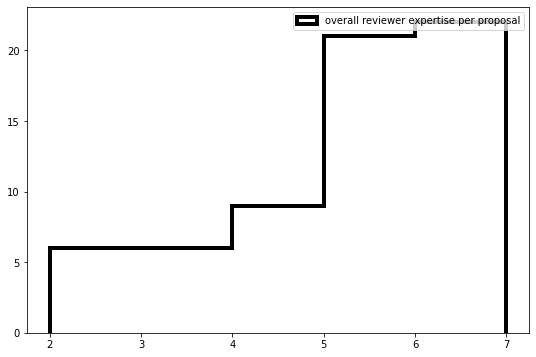

median, mean: 5.0 4.734375


array([[5, 'MKT-22005'],
       [6, 'MKT-22006'],
       [4, 'MKT-22008'],
       [5, 'MKT-22013'],
       [2, 'MKT-22015'],
       [6, 'MKT-22017'],
       [6, 'MKT-22018'],
       [4, 'MKT-22023'],
       [5, 'MKT-22027'],
       [5, 'MKT-22029'],
       [5, 'MKT-22032'],
       [6, 'MKT-22033'],
       [5, 'MKT-22034'],
       [6, 'MKT-22037'],
       [4, 'MKT-22038'],
       [4, 'MKT-22039'],
       [5, 'MKT-22044'],
       [5, 'MKT-22045'],
       [3, 'MKT-22046'],
       [5, 'MKT-22048'],
       [6, 'MKT-22049'],
       [5, 'MKT-22050'],
       [6, 'MKT-22054'],
       [4, 'MKT-22059'],
       [2, 'MKT-22064'],
       [5, 'MKT-22065'],
       [5, 'MKT-22069'],
       [6, 'MKT-22072'],
       [5, 'MKT-22075'],
       [6, 'MKT-22077'],
       [5, 'MKT-22079'],
       [3, 'MKT-22086'],
       [5, 'MKT-22089'],
       [5, 'MKT-22090'],
       [6, 'MKT-22094'],
       [6, 'MKT-22096'],
       [3, 'MKT-22098'],
       [4, 'MKT-22101'],
       [6, 'MKT-22102'],
       [6, 'MKT-22104'],


In [107]:
plt.hist(rev_max_arr.sum(axis=1), histtype='step', bins=range(np.min(rev_max_arr.sum(axis=1)),2+np.max(rev_max_arr.sum(axis=1))), linewidth=4,color='k',label='overall reviewer expertise per proposal')
#bins=1+np.max(rev_max_arr.sum(axis=1))-np.min(rev_max_arr.sum(axis=1))
plt.legend()
plt.savefig('total_reviewer_expertise_per_proposal_hist.png')
plt.show()
print('median, mean:', np.median(rev_max_arr.sum(axis=1)),np.mean(rev_max_arr.sum(axis=1)))
np.column_stack((rev_max_arr.sum(axis=1),df_cat['PSS ID']))
#rev_max_arr.sum(axis=1)

#range(14,25)

64


1

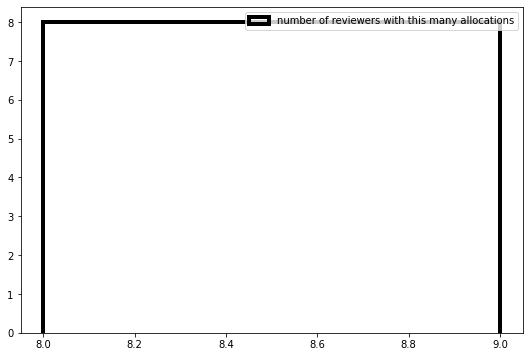

In [108]:
#column sums of the assignment: number of reviews per reviewer
col_sum=[]
print(np.count_nonzero(assignment))
for el in assignment:
    col_sum.append(np.count_nonzero(el))#print(np.count_nonzero(el))

#print(np.column_stack((og_rev_idx,col_sum)))

plt.hist(col_sum, histtype='step', bins=range(np.min(col_sum), 2+np.max(col_sum)),linewidth=4, color='k',label='number of reviewers with this many allocations')
#bins=np.max(col_sum) - np.min(col_sum)
plt.legend()
plt.savefig('reviewers_hist.png')

np.max(col_sum) - np.min(col_sum)+1

In [109]:
# check for conflicts of interest in final assignment

icm = np.where(conflict_mask == 1, 0, 1)
#zeroes_mask = np.where(np.array(df_rev_score.transpose()) > 0., 1, 0)[1:-1]
final_conflicts = assignment * icm
print('final conflicts:', np.count_nonzero(final_conflicts))
#icm[6], conflict_mask[6]

final conflicts: 0


In [ ]:
# check no assignments outside observation category



Fernando's (random) matrix zeros:  19
Fernando's (random) Extended zeros:  74
Random Extended: mean, median 3.1549586776859506 3.0
1527.0 484 3.1549586776859506
Random: mean, median 4.0 3.89453125 4.0 237 410


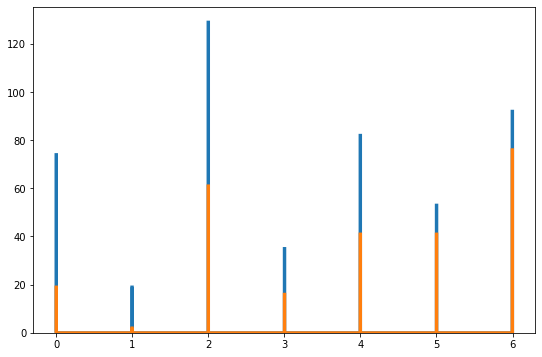

In [111]:
# VERIFICATION:
# Essentially this answers the question of what would be the base case? 
# What distribution of scores would a random assignment yield?

# -----------
# RANDOM Fernando's Matrix (reviewer score distribution)
# -----------

# random gene_matrix
r_gene_matrix = np.random.randint(0, n_r, size=(n_p,4))
r_gene_matrix+1

# max reviewer score matrix ('Fernando's Matrix')
rev_max_arr = np.zeros((n_p, 4))
# all reviewer score list ('Extended Fernando's List')
all_assigned_affinities = []


for cell_idx, topic_set in enumerate(df_cat['CATEGORY LIST']):#iterate over proposals
    rev_a = np.zeros(4)
    for topic in topic_set: #iterate over topic proposals
        #if ((topic != 14) and (topic != 15)):
        if (topic <= 13):
            for rev_idx, rev in enumerate(r_gene_matrix[cell_idx]):#iterate over reviewers
                rev_a[rev_idx] = np.maximum(rev_a[rev_idx], rev_scores[topic-1][rev])
                all_assigned_affinities.append(rev_scores[topic-1][rev])
                #print(cell_idx, topic, rev_idx, rev, rev_scores[topic-1][rev])
                
    #print(rev_a)
    rev_max_arr[cell_idx] = rev_a
    
print('Fernando\'s (random) matrix zeros: ', rev_max_arr.flatten().shape[0] - np.count_nonzero(rev_max_arr))
print('Fernando\'s (random) Extended zeros: ', len(all_assigned_affinities) - np.count_nonzero(np.array(all_assigned_affinities)))

plt.hist(all_assigned_affinities, histtype='step', linewidth=3, bins=1000)

print('Random Extended: mean, median', np.mean(all_assigned_affinities), np.median(all_assigned_affinities))
print(np.sum(all_assigned_affinities), len(all_assigned_affinities), np.sum(all_assigned_affinities)/len(all_assigned_affinities))

np.mean(rev_max_arr.sum(axis=1))

plt.hist(rev_max_arr.astype(int).flatten(), histtype='step', linewidth=3, bins=1000)#.sum(axis=0)
print('Random: mean, median',np.median(rev_max_arr), np.mean(rev_max_arr), np.min(rev_max_arr.sum(axis=1)), np.count_nonzero(rev_max_arr.astype(int).flatten()), np.count_nonzero(all_assigned_affinities))

plt.savefig('random_hist.png')